In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta = prms['delta'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)

        rt = []

        for _ in range(100):
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0}) 

In [4]:
data = pd.read_csv('../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [5]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
exp_speed = pd.read_csv('_prms/exp_speed.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [6]:
hyp_speed.BIC.sum(), exp_speed.BIC.sum(), jddm_speed.BIC.sum(), bddm_speed.BIC.sum()

(-3624.75597449161,
 -3619.1671701841624,
 -3475.2806036987904,
 1305.7264425895928)

In [7]:
hyp_accuracy.BIC.sum(), exp_accuracy.BIC.sum(), jddm_accuracy.BIC.sum(), bddm_accuracy.BIC.sum()

(1479.8985344781509, 1439.3267833698962, 1604.7311821952492, 3920.393304685396)

In [8]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 14.66it/s]


In [9]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.45it/s]


In [10]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 15.66it/s]


In [11]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 15.23it/s]


In [12]:
def plot_model_pred(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 25)
    temp = pred.groupby(by=['sbj'])[var].mean()
    plt.errorbar(x= x, 
                 y= pred[var].mean(),
                 yerr=err*temp.values.std()/np.sqrt(25), 
                 label=label, c=color);

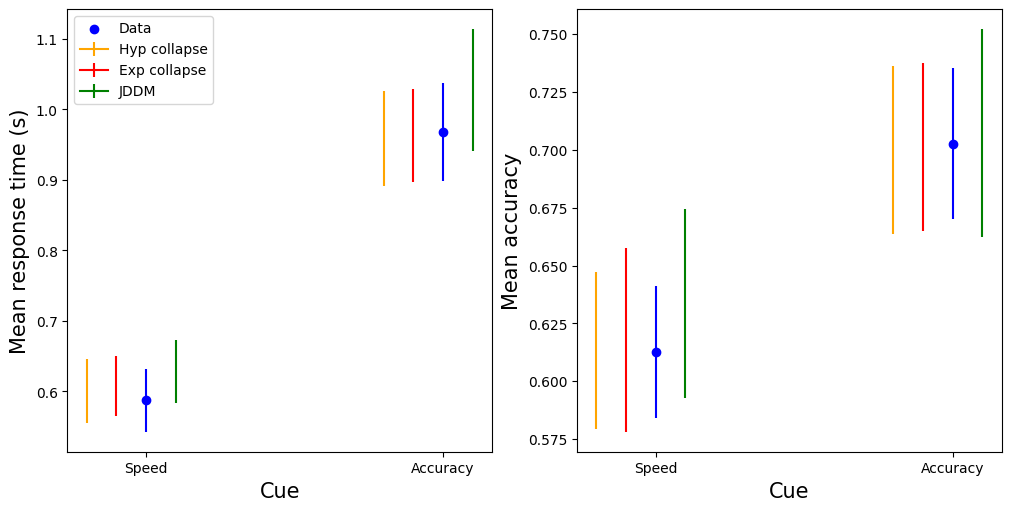

In [15]:
fig = plt.figure(figsize=(10, 5), layout='constrained')
# fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)
plot_model_pred(pred_hyp_sp, 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'rt', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_sp, 'rt', 'green', 1, 'JDDM')

plot_model_pred(pred_hyp_ac, 'rt', 'orange', 8, None)
plot_model_pred(pred_exp_ac, 'rt', 'red', 9, None)
plot_model_pred(pred_jddm_ac, 'rt', 'green', 11, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['RT'].mean()
plt.errorbar(x=0, y=data_speed['RT'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=0, 
            y=data_speed['RT'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['RT'].mean()
plt.errorbar(x=10, y=data_accuracy['RT'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=10, 
            y=data_accuracy['RT'].mean(), 
            c='blue');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend();
plt.xticks([0, 10], ['Speed', 'Accuracy']);

plt.subplot(122)
plot_model_pred(pred_hyp_sp, 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'accuracy', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm_sp, 'accuracy', 'green', 1, 'JDDM')

plot_model_pred(pred_hyp_ac, 'accuracy', 'orange', 8, None)
plot_model_pred(pred_exp_ac, 'accuracy', 'red', 9, None)
plot_model_pred(pred_jddm_ac, 'accuracy', 'green', 11, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=0, y=data_speed['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=0, 
            y=data_speed['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=10, y=data_accuracy['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=10, 
            y=data_accuracy['correct'].mean(), 
            c='blue');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)
plt.xticks([0, 10], ['Speed', 'Accuracy']);